In [5]:
# NOTE: each annotation file has a column of tokens and a column of NER-tags, AND the num of rows of two files should be the same
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.ticker as mtick
from disagreement_extraction import create_disagreement_df, get_disagreeement_df2files

from collections import defaultdict

In [6]:
def sampling(num_samples,df,savepath=None):
    """
    num_samples: total number of samples wished; sampling after disagreement type proportion
    df: dataframe obtained from create_disagreement_df function
    savepath: path for saving the randomly selected samples

    return: saving an Excel file with two extra column: ['disagreement subtype','reasoning']

    function usage: the user can annotate/eye-balling examples in the saved Excel. And Later analysis the Excel as Dataframe
    """
    # get the number of samples for each disagreement type
    num_dict = {}
    for dis_type in df['disagreement type'].unique():
        num_dict[dis_type] = round(num_samples * (len(df[df['disagreement type']==dis_type]) / len(df)))
    # out df
    new_df = pd.DataFrame(columns=list(df.columns)+['disagreement major types','disagreement subtypes'])
    # add samples to out df
    for dis_type in num_dict:
        new_df=pd.concat([new_df,df[df['disagreement type']==dis_type].sample(num_dict[dis_type])],ignore_index=True)
    if savepath:
        new_df.to_excel(savepath,index=False)
    return new_df

# automatic disagreement type post-processing
def replace_type(row):
    if row['disagreement type'] == "full_disagreement":
        row['disagreement type']='Tag'
    elif row['disagreement type'] == 'o_disagreement':
        row['disagreement type'] = 'Missing'
    elif (row['disagreement type'] == "including_disagreement" or row['disagreement type'] == "partial_disagreement") and row['entity type1'] == row['entity type2']:
        row['disagreement type'] = 'Span'
    elif (row['disagreement type'] == "including_disagreement" or row['disagreement type'] == "partial_disagreement") and row['entity type1'] != row['entity type2']:
        row['disagreement type'] = 'Both'
    return row

def get_dis_combi(row,sorting=False):
    type1 = row['entity type1']
    type2 = row['entity type2']
    if not type1:
        type1 = "O"
    if not type2:
        type2 = "O"

    if sorting:
        return "-".join(sorted([type1,type2]))
    else:
        return type1+"-"+type2

In [7]:
df_dict = {}

# English origin-clean
en_origin_path = '../datasets/en-conll2003-original/en-conll2003-original-test-tokaligned.tsv'
en_cleanconcll_path = '../datasets/en-conll2003-clean/en-conll2003-clean-test-tokaligned.tsv'
en_origin_clean_df = get_disagreeement_df2files(en_origin_path,en_cleanconcll_path)
df_dict['enCoNLL_original-clean']=en_origin_clean_df

# English conllpp-clean
en_conllpp_path = '../datasets/en-conll2003-conllpp/en-conll2003-conllpp-test-tokaligned.tsv'
en_conllpp_clean_df = get_disagreeement_df2files(en_conllpp_path,en_cleanconcll_path)
df_dict['enCoNLL_conllpp-clean']=en_conllpp_clean_df

#English reiss-clean
en_reiss_path = '../datasets/en-conll2003-reiss/en-conll2003-reiss-test-tokaligned.tsv'
en_reis_clean_df = get_disagreeement_df2files(en_reiss_path,en_cleanconcll_path)
df_dict['enCoNLL_reiss-clean']=en_reis_clean_df

# Danish plank-hvingelby
dan_plank_path = '../datasets/da-ddt-plank/da-ddt-plank-test-tokaligned.tsv'
dan_hvingelby_path = '../datasets/da-ddt-hvingelby/da-ddt-hvingelby-test-tokaligned.tsv'
dan_plank_hvingelby_df = get_disagreeement_df2files(dan_plank_path,dan_hvingelby_path)
df_dict['dan_plank-hvingelby']=dan_plank_hvingelby_df

# BarNER
src_folder_bar = '../datasets/bar-barner'
bar_df = create_disagreement_df(src_folder_bar,['wiki','tweet'],['annotator2', 'annotator1'],['test'])
# Logan's change: only look at test to be consistent with English and Danish # ['train','dev','test']
df_dict['bavarian_annotators']=bar_df

In [8]:
# change disagreement labels to TAG, SPAN, BOTH, Missing
for k,df in df_dict.items():
    df=df.apply(lambda row:replace_type(row), axis=1)
    #get disagreement combi
    df['disagreement combi']=df.apply(lambda row:get_dis_combi(row,sorting=False),axis=1)
    df_dict[k]=df

/var/folders/75/2rtf19ys5s16xg82h6zj9mjw0000gn/T/ipykernel_29007/2236049209.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df2plot=pd.concat([df2plot,plot_df],ignore_index=True)


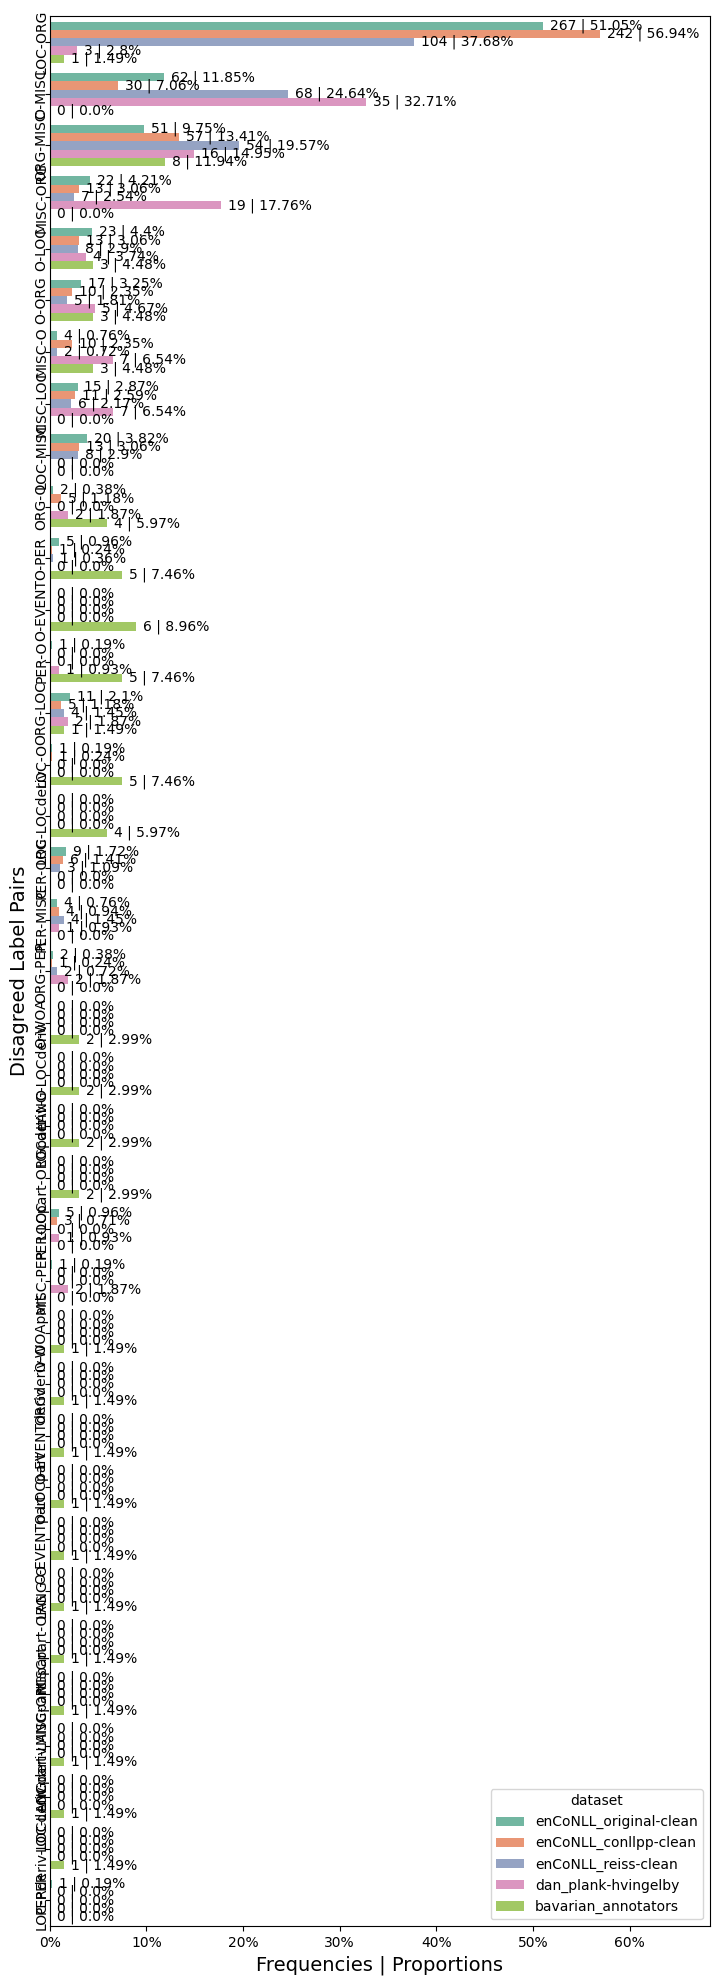

In [9]:
# grouped counter labels ; TAG class + Missing class ALL horizontal Bar plot
# for disagreement counter labels
df2plot = pd.DataFrame(columns=['disagreement combi','proportion','count','dataset'])
for k, df in df_dict.items():
    used_df = df_dict[k][(df_dict[k]['disagreement type']=='Tag') | (df_dict[k]['disagreement type']=='Missing')]
    # new code
    plot_df = pd.concat([used_df.value_counts('disagreement combi',normalize=True),
                         used_df.value_counts('disagreement combi')],axis=1).reset_index()

    plot_df['dataset']=k
    df2plot=pd.concat([df2plot,plot_df],ignore_index=True)
df2plot['proportion']=round(df2plot['proportion'] * 100,2)
for counter_label in df2plot['disagreement combi'].unique():
    for dataset in df2plot['dataset'].unique():
        if df2plot[(df2plot['disagreement combi']==counter_label) & (df2plot['dataset']==dataset)].empty:
            add_df = pd.DataFrame({'disagreement combi':[counter_label],'dataset':[dataset],'proportion':[0.0],'count':[0]})
            df2plot = pd.concat([df2plot,add_df],ignore_index=True)


# order the disagreement combi by its sum proportion
for counter_label in df2plot['disagreement combi'].unique():
    for dataset in df2plot['dataset'].unique():
        if df2plot[(df2plot['disagreement combi']==counter_label) & (df2plot['dataset']==dataset)].empty:
            add_df = pd.DataFrame({'disagreement combi':[counter_label],'dataset':[dataset],'proportion':[0.0],'count':[0]})
            df2plot = pd.concat([df2plot,add_df],ignore_index=True)

combi_percentage = defaultdict(float)
for _,row in df2plot.iterrows():
    combi_percentage[row['disagreement combi']] += row['proportion']
combi_percentage = {k: v for k, v in sorted(combi_percentage.items(), key=lambda item: item[1],reverse=True)}
filtered_df = df2plot[df2plot['disagreement combi'].isin(combi_percentage)]

# bring the same disagreement type order for each dataset
dis_type_order = {k:ix for ix,k in enumerate(combi_percentage)}
dis_type_order.update({k:ix for ix,k in enumerate(filtered_df['dataset'].unique())})
filtered_df=filtered_df.sort_values(by=['dataset','disagreement combi'],key=lambda x:x.map(dis_type_order))

plt.figure(figsize=(8, 8*2.5))
splot = sns.barplot(y="disagreement combi", x="proportion", hue="dataset",
                    data=filtered_df, palette='Set2')
for ix,p in enumerate(splot.patches):
    if p.get_height():
        count = filtered_df.iloc[ix]['count']
        splot.annotate(f"{count} | {p.get_width()}%",
                       # (p.get_x() + p.get_width() / 2., p.get_height()),
                       # ha='center', va='bottom',
                       (p.get_width(),p.get_y()+p.get_height()/2.),
                       ha='left',
                       va='center',
                       xytext=(5,0),
                       textcoords='offset points',
                       # rotation=90,
                       fontsize=10
                       )

plt.xlabel("Frequencies | Proportions", size=14)
plt.ylabel("Disagreed Label Pairs", size=14)
plt.yticks(rotation=90, ha='center', rotation_mode='anchor')
splot.xaxis.set_major_formatter(mtick.PercentFormatter())
plt.tight_layout()
plt.margins(x=0.2)
plt.savefig('../figs/grouped_counter_labels_TAGwMISSING_Sum.png')
plt.show()



/var/folders/75/2rtf19ys5s16xg82h6zj9mjw0000gn/T/ipykernel_29007/3372079731.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df2plot=pd.concat([df2plot,plot_df],ignore_index=True)


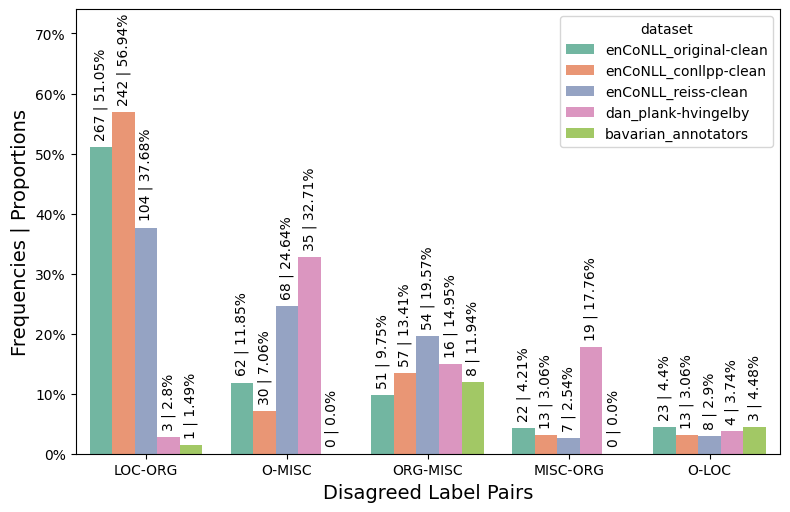

In [10]:
# grouped counter labels ; TAG class + Missing class TOP 5
# for disagreement counter labels
df2plot = pd.DataFrame(columns=['disagreement combi','proportion','count','dataset'])
for k, df in df_dict.items():
    used_df = df_dict[k][(df_dict[k]['disagreement type']=='Tag') | (df_dict[k]['disagreement type']=='Missing')]
    plot_df = pd.concat([used_df.value_counts('disagreement combi',normalize=True),
                         used_df.value_counts('disagreement combi')],axis=1).reset_index()

    plot_df['dataset']=k
    df2plot=pd.concat([df2plot,plot_df],ignore_index=True)
df2plot['proportion']=round(df2plot['proportion'] * 100,2)
for counter_label in df2plot['disagreement combi'].unique():
    for dataset in df2plot['dataset'].unique():
        if df2plot[(df2plot['disagreement combi']==counter_label) & (df2plot['dataset']==dataset)].empty:
            add_df = pd.DataFrame({'disagreement combi':[counter_label],'dataset':[dataset],'proportion':[0.0],'count':[0]})
            df2plot = pd.concat([df2plot,add_df],ignore_index=True)

# order the disagreement combi by its sum proportion
for counter_label in df2plot['disagreement combi'].unique():
    for dataset in df2plot['dataset'].unique():
        if df2plot[(df2plot['disagreement combi']==counter_label) & (df2plot['dataset']==dataset)].empty:
            add_df = pd.DataFrame({'disagreement combi':[counter_label],'dataset':[dataset],'proportion':[0.0],'count':[0]})
            df2plot = pd.concat([df2plot,add_df],ignore_index=True)

combi_percentage = defaultdict(float)
for _,row in df2plot.iterrows():
    combi_percentage[row['disagreement combi']] += row['proportion']
combi_percentage = {k: v for k, v in sorted(combi_percentage.items(), key=lambda item: item[1],reverse=True)[:5]}
filtered_df = df2plot[df2plot['disagreement combi'].isin(combi_percentage)]

# bring the same disagreement type order for each dataset
dis_type_order = {k:ix for ix,k in enumerate(combi_percentage)}
dis_type_order.update({k:ix for ix,k in enumerate(filtered_df['dataset'].unique())})
filtered_df=filtered_df.sort_values(by=['dataset','disagreement combi'],key=lambda x:x.map(dis_type_order))

plt.figure(figsize=(8, 6))
splot = sns.barplot(x="disagreement combi", y="proportion", hue="dataset",
                    data=filtered_df, palette='Set2')
for ix,p in enumerate(splot.patches):
    if p.get_width():
        count = filtered_df.iloc[ix]['count']
        splot.annotate(f"{count} | {p.get_height()}%",
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='bottom',
                       xytext=(0, 5),
                       textcoords='offset points',
                       rotation=90,
                       fontsize=10
                       )

plt.xlabel("Disagreed Label Pairs", size=14)
plt.ylabel("Frequencies | Proportions", size=14)
splot.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.tight_layout()
plt.margins(y=0.30)
plt.savefig('../figs/grouped_counter_labels_TAGwMISSING_SumPropTop5.png')
plt.show()



/var/folders/75/2rtf19ys5s16xg82h6zj9mjw0000gn/T/ipykernel_29007/2025848832.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df2plot=pd.concat([df2plot,plot_df],ignore_index=True)


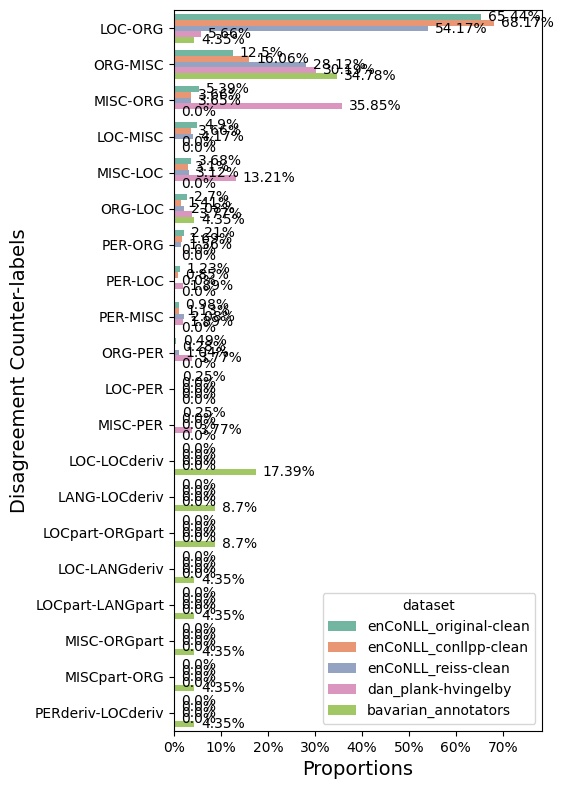

In [11]:
# grouped counter labels; ONLY Tag Disagreement
# for disagreement counter labels
df2plot = pd.DataFrame(columns=['disagreement combi','proportion','count','dataset'])
for k, df in df_dict.items():
    used_df = df_dict[k][df_dict[k]['disagreement type']=='Tag']

    # get count and proportion
    plot_df = pd.concat([used_df.value_counts('disagreement combi',normalize=True),
                         used_df.value_counts('disagreement combi')],axis=1).reset_index()

    plot_df['dataset']=k
    df2plot=pd.concat([df2plot,plot_df],ignore_index=True)
df2plot['proportion']=round(df2plot['proportion'] * 100,2)


for counter_label in df2plot['disagreement combi'].unique():
    for dataset in df2plot['dataset'].unique():
        if df2plot[(df2plot['disagreement combi']==counter_label) & (df2plot['dataset']==dataset)].empty:
            add_df = pd.DataFrame({'disagreement combi':[counter_label],'dataset':[dataset],'proportion':[0.0],'count':[0]})
            df2plot = pd.concat([df2plot,add_df],ignore_index=True)

combi_percentage = defaultdict(float)
for _,row in df2plot.iterrows():
    combi_percentage[row['disagreement combi']] += row['proportion']
combi_percentage = {k: v for k, v in sorted(combi_percentage.items(), key=lambda item: item[1],reverse=True)}
filtered_df = df2plot[df2plot['disagreement combi'].isin(combi_percentage)]

plt.figure(figsize=(6,8))
splot = sns.barplot(y="disagreement combi", x="proportion", hue="dataset",
                    data=filtered_df, palette='Set2')
for _,p in enumerate(splot.patches):
    if p.get_height():
        splot.annotate(f"{p.get_width()}%",
                       (p.get_width(),p.get_y()+p.get_height()/2.),
                       ha='left',
                       va='center',
                       xytext=(5, 0),
                       textcoords='offset points',
                       rotation=0,
                       fontsize=10
                       )

plt.xlabel("Proportions", size=14)
plt.ylabel("Disagreement Counter-labels", size=14)
splot.xaxis.set_major_formatter(mtick.PercentFormatter())
plt.tight_layout()
plt.margins(x=0.15)
# plt.savefig('../figs/grouped_counter_labels_TAG.png')
plt.show()

/var/folders/75/2rtf19ys5s16xg82h6zj9mjw0000gn/T/ipykernel_29007/1535717863.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df2plot=pd.concat([df2plot,plot_df],ignore_index=True)


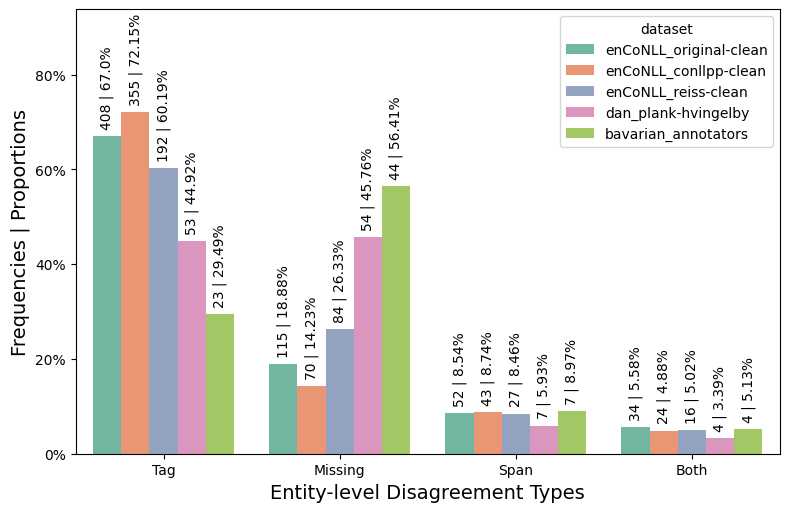

In [12]:
#grouped disagreement class
# for disagreement class
df2plot = pd.DataFrame(columns=['disagreement type','proportion','count','dataset'])
for k, df in df_dict.items():
    used_df = df_dict[k]
    plot_df = pd.concat([used_df.value_counts('disagreement type',normalize=True),
                         used_df.value_counts('disagreement type')],axis=1).reset_index()

    plot_df['dataset']=k
    df2plot=pd.concat([df2plot,plot_df],ignore_index=True)
df2plot['proportion']=round(df2plot['proportion'] * 100,2)

# bring the same disagreement type order for each dataset
dis_type_order = {'Tag':0,'Missing':1,'Span':2,'Both':3}
dis_type_order.update({k:ix for ix,k in enumerate(df2plot['dataset'].unique())})
df2plot=df2plot.sort_values(by=['dataset','disagreement type'],key=lambda x:x.map(dis_type_order))
plt.figure(figsize=(8, 6))
splot = sns.barplot(x="disagreement type", y="proportion", hue="dataset",
                    data=df2plot, palette='Set2')

for ix,p in enumerate(splot.patches):
    if p.get_width():
        count = df2plot.iloc[ix]['count']
        splot.annotate(f"{count} | {p.get_height()}%",
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='bottom',
                       xytext=(0, 5),
                       textcoords='offset points',
                       rotation=90,
                       size=10
                       )

plt.ylabel("Frequencies | Proportions", size=14)
plt.xlabel("Entity-level Disagreement Types", size=14)
splot.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.tight_layout()
plt.margins(y=0.30)
plt.savefig('../figs/grouped_barplot_wSimilarDivergences_coarseBar.png')
plt.show()